# Waste classification

## 1. Setup

### 1. Import libraries

In [1]:
# Standard Libraries
import os
import time
import shutil
import random
import tarfile

# Numerical & Data Processing
import numpy as np

# Machine Learning & Data Splitting
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning & PyTorch
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.optim as optim
import torch.utils as utils
from torchvision import models, transforms

# Image Processing
from PIL import Image

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Global constants

In [2]:
RES_DIR = os.path.join("..", "res")
DATASET_DIR = os.path.join(RES_DIR, "dataset")
OUTPUT_DIR = os.path.join(RES_DIR, "output")

TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
VAL_DIR = os.path.join(OUTPUT_DIR, "val")
TEST_DIR = os.path.join(OUTPUT_DIR, "test")
MODEL_DIR = os.path.join(OUTPUT_DIR, "model")

MODEL_NAME = "model.pt"

CLASSES = os.listdir(DATASET_DIR)
NUM_CLASSES = len(CLASSES)
SEED = 42
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15

SHOW_VISUALIZATIONS = True  # Avoid visualization diagrams
TESTING = False  # Avoid time consuming operations (K-Fold, model training)

## 2. Understanding the dataset

### 1. Get the paths and labels all images

In [3]:
paths = []
labels = []

for idx, label in enumerate(os.listdir(DATASET_DIR)):
    class_dir = os.path.join(DATASET_DIR, label)
    for video in os.listdir(class_dir):
        image_path = os.path.join(class_dir, video)

        paths.append(image_path)
        labels.append(idx)

### 2. Plot the class distribution

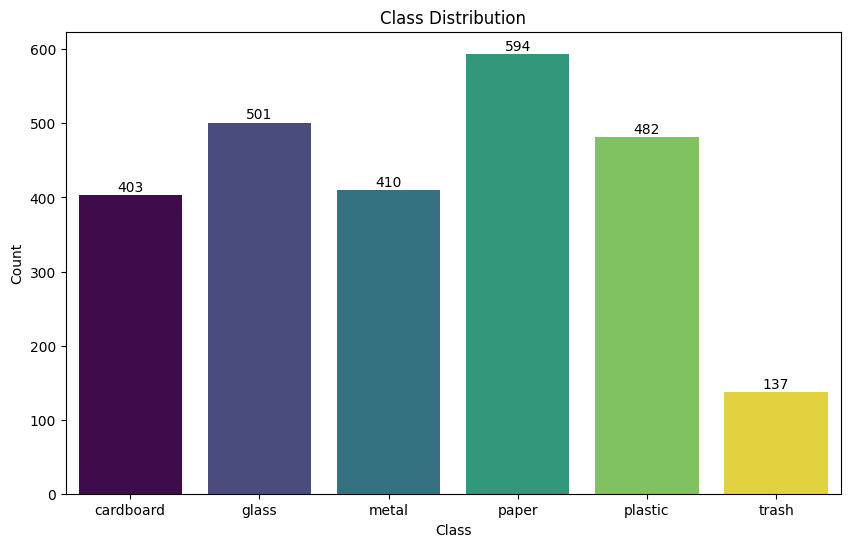

In [4]:
if SHOW_VISUALIZATIONS:
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=unique, y=counts, palette="viridis", hue=unique, legend=False)
    plt.title("Class Distribution")

    plt.xticks(ticks=np.arange(NUM_CLASSES), labels=CLASSES)

    plt.xlabel("Class")
    plt.ylabel("Count")

    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha="center", va="bottom", fontsize=10)

    plt.show()
    plt.clf()
    plt.close()

## 3. Exploratory Data Analysis (EDA)

### 1. Visualize a sample of images

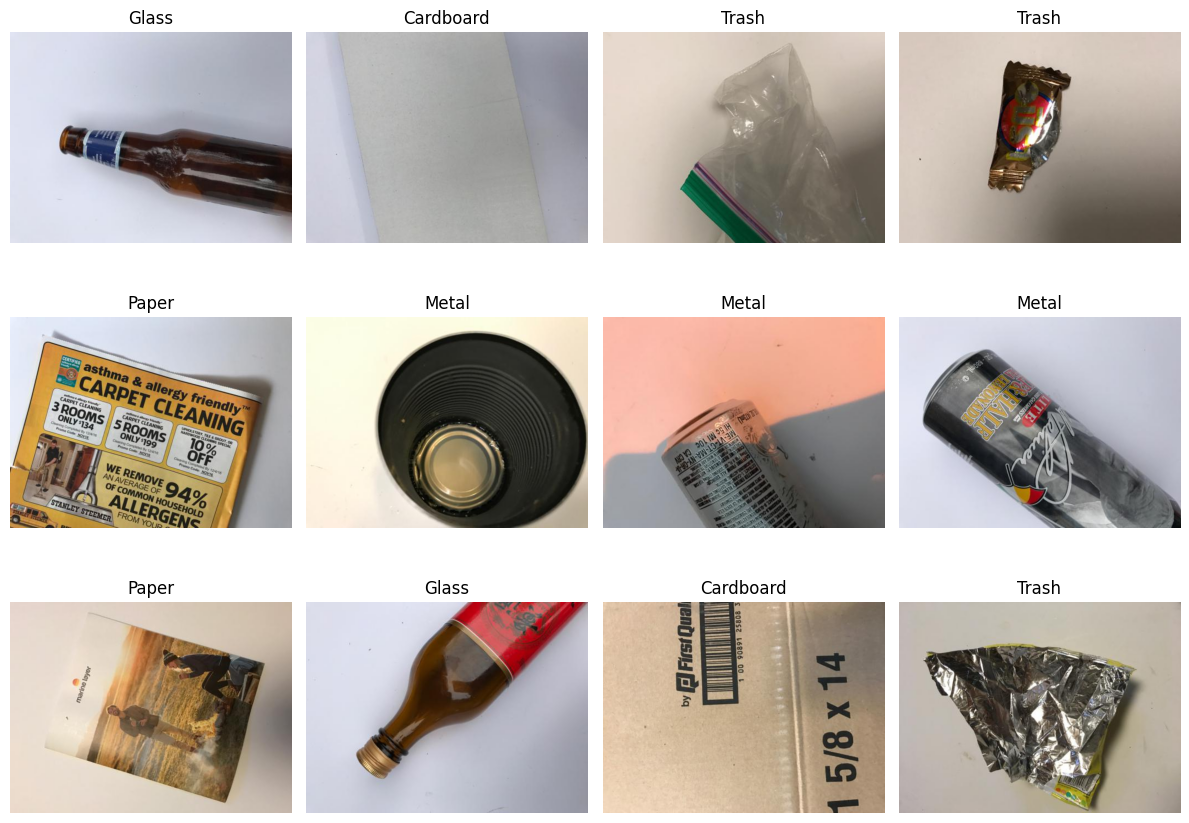

In [5]:
if SHOW_VISUALIZATIONS:
    num_images = 12
    columns = 4
    rows = (num_images + columns - 1) // columns

    plt.figure(figsize=(columns * 3, rows * 3))

    for i in range(num_images):
        # Get random class
        class_name = random.choice(CLASSES)
        class_path = os.path.join(DATASET_DIR, class_name)

        # Get random image from that class
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)

        # Load and display image
        img = Image.open(image_path)
        plt.subplot(rows, columns, i + 1)
        plt.imshow(img)
        plt.title(class_name.title())
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.close()

## 4. Dataset Preparation

### 1. Create directories for the train, validation, and test set

In [6]:
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

### 2. Split the dataset into a train, validation or test set

In [7]:
# Check if dataset is already split
if all(os.path.exists(d) and len(os.listdir(d)) > 0 for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]):
    print("Dataset already split.")
else:
    labels = os.listdir(DATASET_DIR)

    for label in labels:
        label_path = os.path.join(DATASET_DIR, label)

        os.makedirs(os.path.join(TRAIN_DIR, label), exist_ok=True)
        os.makedirs(os.path.join(VAL_DIR, label), exist_ok=True)
        os.makedirs(os.path.join(TEST_DIR, label), exist_ok=True)

        images = os.listdir(label_path)
        train_paths, temp_paths = train_test_split(images, train_size=TRAIN_SIZE)
        val_paths, test_paths = train_test_split(temp_paths, train_size=(VAL_SIZE / (1 - TRAIN_SIZE)))

        for image in train_paths:
            shutil.copy(os.path.join(label_path, image), os.path.join(TRAIN_DIR, label, image))

        for image in train_paths:
            shutil.copy(os.path.join(label_path, image), os.path.join(VAL_DIR, label, image))

        for image in test_paths:
            shutil.copy(os.path.join(label_path, image), os.path.join(TEST_DIR, label, image))

    print(f"Dataset has been split.")

Dataset already split.


## 5. Data Loading & Preprocessing

### 1. ML constants

In [8]:
BATCH_SIZE = 256
EPOCHS = 1000
LEARNING_RATE = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2. Transforms (and augmentations) for each set

In [9]:
train_transform = transforms.Compose([
    transforms.Resize(256),  # Resize images to 256x256
    transforms.RandomResizedCrop(224),   # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),  # Convert to tensor & scale to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to tensor & scale to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### 3. Getting directory paths and labels

In [10]:
def get_path_and_labels(*directories):
    paths = []
    labels = []

    for directory in directories:
        for idx, label in enumerate(CLASSES):
            class_dir = os.path.join(directory, label)
            for image in os.listdir(class_dir):
                path = os.path.join(class_dir, image)

                paths.append(path)
                labels.append(idx)

    return paths, labels

### 4. Creating the datasets

In [11]:
class ImageDataset(utils.data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.paths[idx])
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]

        return image, torch.tensor(label, dtype=torch.long)

In [12]:
def create_dataset(directory, transform=None):
    paths, labels = get_path_and_labels(directory)
    return ImageDataset(paths, labels, transform=transform)

### 5. Creating the dataloaders

In [13]:
def prepare(dataset, shuffle=False):
    return torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=shuffle, pin_memory=True
    )

## 6. Model Development

### 1. Defining the model

In [14]:
def create_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Freeze feature extraction layers
    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer4.parameters():
        param.requires_grad = True

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    return model.to(device)

## 7. Evaluation with cross validation

### 1. Train the model

In [15]:
def get_class_weights(train_loader):
    all_labels = []

    for _, labels in train_loader:
        all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)  # Convert list to NumPy array

    # Compute class weights
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(all_labels), y=all_labels)

    # Convert to PyTorch tensor
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    return class_weights_tensor

In [16]:
def run_model(model, train_loader, val_loader, epochs=EPOCHS, early_stopping_patience=5, reduce_lr_patience=5, verbose=1, model_path=OUTPUT_DIR, model_name="model.pt"):
    start = time.time()

    criterion = nn.CrossEntropyLoss(weight=get_class_weights(train_loader))
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=reduce_lr_patience, factor=0.5)

    history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}
    
    if model_path is not None:
        best_model_path = os.path.join(model_path, model_name)
        torch.save(model.state_dict(), best_model_path)  # Save initial model

    best_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(epochs):
        for phase, dataset in [("train", train_loader), ("val", val_loader)]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            correct, total = 0, 0

            for images, labels in dataset:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    preds = outputs.argmax(dim=1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / len(dataset.dataset)
            epoch_acc = correct / total

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_accuracy"].append(epoch_acc)

            if phase == "val":
                scheduler.step(epoch_loss)  # Reduce LR based on val_loss
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    if model_path is not None:
                        torch.save(model.state_dict(), best_model_path)
                        
                    epochs_no_improve = 0  # Reset early stopping counter
                else:
                    epochs_no_improve += 1
        
        if verbose > 0:
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, Train Accuracy: {history['train_accuracy'][-1]:.4f}, "
                  f"Val Loss: {history['val_loss'][-1]:.4f}, Val Accuracy: {history['val_accuracy'][-1]:.4f}, "
                  f"LR: {optimizer.param_groups[0]['lr']}")
        
        if epochs_no_improve >= early_stopping_patience:
            if verbose > 0:
                print(f"Early stopping triggered after {epoch+1} epochs without improvement in val_loss.")
            break

    time_elapsed = time.time() - start
    if verbose > 0:
        print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best validation Loss: {best_loss:.4f} and it's respective accuracy: {best_acc:.4f}.")

    return history

In [17]:
def plot_metric(history, metric, path=None):
    plt.figure(figsize=(10, 6))

    epochs = np.arange(1, len(history[f"train_{metric}"]) + 1)

    plt.plot(epochs, history[f"train_{metric}"], label=f"train_{metric}")
    plt.plot(epochs, history[f"val_{metric}"], label=f"val_{metric}")

    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    
    if path is not None:
        plt.savefig(os.path.join(path, f"{metric}.png"))
    else:
        plt.show()
        
    plt.clf()
    plt.close()

### 2. Evaluate the model

In [18]:
def test_model_k_fold(k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

    accuracies = []
    losses = []

    X, y = get_path_and_labels(TRAIN_DIR, VAL_DIR)

    for fold_no, (train_index, val_index) in enumerate(skf.split(X, y)):
        start_time = time.time()

        X_train, X_val = np.array(X)[train_index], np.array(X)[val_index]
        y_train, y_val = np.array(y)[train_index], np.array(y)[val_index]

        train_dataset = ImageDataset(X_train, y_train, transform=train_transform)
        val_dataset = ImageDataset(X_val, y_val, transform=test_transform)

        train_loader = prepare(train_dataset, shuffle=True)
        val_loader = prepare(val_dataset)

        model = create_model()

        history = run_model(model, train_loader, val_loader, epochs=EPOCHS, early_stopping_patience=10, reduce_lr_patience=2, verbose=0, model_path=None)

        accuracies.append(history["val_accuracy"][-1] * 100)
        losses.append(history["val_loss"][-1])

        elapsed_time = time.time() - start_time

        print(f"Fold {fold_no + 1}/{k} - Completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    print(f"K-Fold completed! Average validation accuracy: {np.mean(accuracies):.2f}%. Average validation loss: {np.mean(losses):.2f}.")

### 3. Training and evaluating the model using stratified K-Fold

In [19]:
if TESTING:
    test_model_k_fold(k=5)

## 8. Training the final model

### 1. Preparing the datasets

In [20]:
train_dataset = create_dataset(directory=TRAIN_DIR, transform=train_transform)
val_dataset = create_dataset(directory=VAL_DIR, transform=test_transform)
test_dataset = create_dataset(directory=TEST_DIR, transform=test_transform)

### 2. Preparing the dataloaders

In [21]:
train_loader = prepare(train_dataset, shuffle=True)
val_loader = prepare(val_dataset)
test_loader = prepare(test_dataset)

### 3. Training the model

In [22]:
history = None
model_dir = os.path.join(OUTPUT_DIR, "model")

if TESTING:
    model = create_model()
    os.makedirs(model_dir, exist_ok=True)

    history = run_model(model, train_loader, val_loader, epochs=EPOCHS, early_stopping_patience=10, reduce_lr_patience=2, model_path=model_dir, model_name=MODEL_NAME)

### 4. Plotting accuracy and loss metrics

In [23]:
if history and SHOW_VISUALIZATIONS:
    plot_metric(history, "accuracy", model_dir)

if history and SHOW_VISUALIZATIONS:
    plot_metric(history, "loss", model_dir)

## 9. Inference

### 1. Loading the trained model

In [24]:
model = create_model()
model.load_state_dict(torch.load(os.path.join(model_dir, MODEL_NAME), weights_only=True))

<All keys matched successfully>

### 2. Evaluate the trained model

In [25]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            
            predictions.extend(predicted.cpu().numpy())

    return np.array(predictions)

In [26]:
y_pred = evaluate_model(model, test_loader)

### 3. Get the true labels for the test set

In [27]:
def get_true_labels(test_loader):
    true_labels = []
    for _, labels in test_loader:
        true_labels.extend(labels.numpy())

    return np.array(true_labels)

In [28]:
y_true = get_true_labels(test_loader)

### 4. Compute and plot confusion matrix

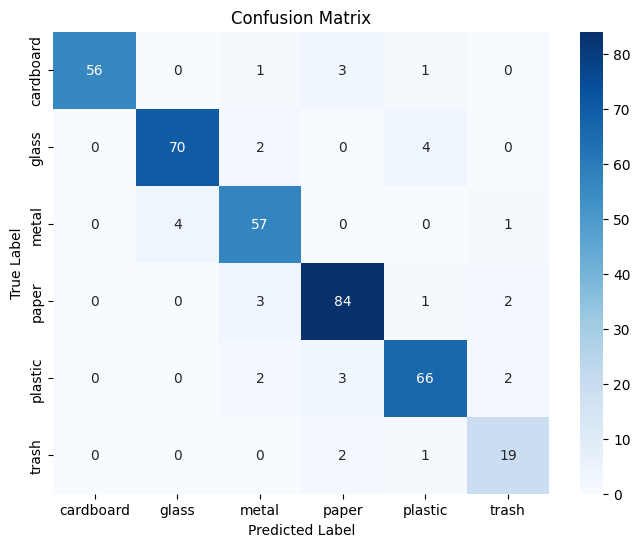

In [29]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(model_dir, "conf_matrix.png"), dpi=300)
plt.show()
plt.close()

### 5. Compute and display the classification report (including precision, recall and f1-score)

In [30]:
print(classification_report(y_true, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

   cardboard       1.00      0.92      0.96        61
       glass       0.95      0.92      0.93        76
       metal       0.88      0.92      0.90        62
       paper       0.91      0.93      0.92        90
     plastic       0.90      0.90      0.90        73
       trash       0.79      0.86      0.83        22

    accuracy                           0.92       384
   macro avg       0.91      0.91      0.91       384
weighted avg       0.92      0.92      0.92       384



## 10. Conclusion & Next Steps

### 1. Conclusion on Waste Classification Model Performance

The waste classification model demonstrates strong overall performance, achieving an accuracy of 92%. The weighted F1-score of 0.92 further confirms that the model is making balanced predictions across all classes.  

### 2. Class-Specific Insights

- Cardboard shows exceptional performance with an F1-score of 0.96, indicating that it is rarely misclassified.  
- Glass, metal, paper, and plastic** all have F1-scores above 0.90*, suggesting that the model is highly effective at distinguishing these materials.  
- Trash has the lowest F1-score (0.83), indicating that it is the most challenging category for the model. This could be due to its more varied visual characteristics, leading to confusion with other classes.  

### 3. Key Observations

- The macro F1-score (0.91) and recall (0.91) show that the model is consistently accurate across different classes, rather than being biased towards dominant categories.  
- The precision-recall balance is well maintained, meaning the model is not significantly over-predicting or under-predicting any particular class.  
- The higher recall for "trash" (0.86) suggests that the model correctly identifies most actual trash items, though it may sometimes misclassify other items as trash.  

### 4. Potential Improvements

- Enhancing "trash" classification: Collecting more diverse samples or fine-tuning the model on this class could improve its performance.  
- Addressing misclassifications: Analysing the confusion matrix could reveal patterns in misclassifications and guide further refinements.  
- Model deployment considerations: Since the model performs well across classes, it could be suitable for real-world applications such as automated recycling systems or waste sorting robots.  

### 5. Final Verdict

The model is highly effective for waste classification, with only minor areas for improvement, particularly in distinguishing trash from other categories. It is well-suited for practical applications where high precision and recall are required for sustainable waste management.

### 6. Next Steps: Pruning and Quantisation for Deployment

To optimise the model for deployment on mobile and edge devices, the following steps will be undertaken:  
- **Pruning**: Reducing unnecessary parameters to make the model more efficient without significantly impacting accuracy.  
- **Quantisation**: Converting the model to a lower precision format (8-bit integers) to reduce size and improve inference speed.  

These techniques will ensure the model remains lightweight, efficient, and suitable for real-world deployment. 

## 11. Deployment

### 1. Pruning

In [32]:
def apply_pruning(model, amount=0.3):
    # https://pytorch.org/tutorials/intermediate/pruning_tutorial.html
    parameters_to_prune = []

    # Add convolutional and linear layers to prune
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            parameters_to_prune.append((module, "weight"))

    # Apply global unstructured pruning
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount)

    # Make pruning permananet
    for layer, name in parameters_to_prune:
        prune.remove(layer, name)

    return model

In [33]:
model = create_model()
model.load_state_dict(torch.load(os.path.join(model_dir, MODEL_NAME), weights_only=True))
pruned_model = apply_pruning(model, amount=0.3)

### 2. Fine-tuning the pruned model

In [34]:
def fine_tune_model(model, train_loader, epochs=5, model_path=OUTPUT_DIR, model_name="pruned_model.pt"):
    start = time.time()

    criterion = nn.CrossEntropyLoss(weight=get_class_weights(train_loader))
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        print(f"Epoch {epoch+1}/{epochs}")

    # Save fine-tuned model
    if model_path is not None:
        fine_tuned_model_path = os.path.join(model_path, model_name)
        torch.save(model.state_dict(), fine_tuned_model_path)

    elapsed_time = time.time() - start
    print(f"Fine-tuning completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s.")

In [35]:
fine_tune_model(pruned_model, train_loader, epochs=5, model_path=model_dir, model_name=f"pruned_{MODEL_NAME}")

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Fine-tuning completed in 0m 46s.


### 3. Quantisation (Post-Training Dynamic Quantisation)

In [ ]:
def apply_quantisation(model):
    # https://pytorch.org/docs/stable/quantization.html
    quantized_model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
    return quantized_model

In [37]:
model = create_model()
model.load_state_dict(torch.load(os.path.join(model_dir, MODEL_NAME), weights_only=True))
quantised_model = apply_quantisation(model)

torch.save(model.state_dict(), os.path.join(model_dir, f"quantised_{MODEL_NAME}"))

### 4. Pruning and Quantisation

In [ ]:
model = create_model()
model.load_state_dict(torch.load(os.path.join(model_dir, MODEL_NAME), weights_only=True))

pruned_model = apply_pruning(model, amount=0.3)

fine_tune_model(pruned_model, train_loader, epochs=5, model_path="", model_name=f"temp_pruned_{MODEL_NAME}")

pruned_ft_model = create_model()
pruned_ft_model.load_state_dict(torch.load(os.path.join("", f"temp_pruned_{MODEL_NAME}"), weights_only=True))
pruned_and_quantised_model = apply_quantisation(pruned_ft_model)

# Delete the temporary pruned model
os.remove(f"temp_pruned_{MODEL_NAME}")

torch.save(quantised_model.state_dict(), os.path.join(model_dir, f"pruned_and_quantised_{MODEL_NAME}"))

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Fine-tuning completed in 0m 40s.
